The goal here is to plot out `rotSkyPos` and `rotTelPos` distributions for baseline (with and without per-filter rotational dithers) vs. those from the new FBS output (implementing per night rotational dithers). The data is already saved by running `save_rot_data.py` and `save_plot_rot_data_newfbs.py`

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pylab
import healpy as hp
import pandas as pd
import numpy as np
from IPython.display import Image, display

In [2]:
import matplotlib as mpl

fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (15, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True

for key in rcparams: mpl.rcParams[key] = rcparams[key]

**Set up**

In [3]:
data_path = '/global/homes/a/awan/desc/rot_output/'
outdir = data_path

**Get the data**

In [4]:
# get all the files
data_files = [f for f in os.listdir(data_path) if f.endswith('csv')]

# now read in the data
simdatas = {}
for i, file in enumerate(data_files): # loop over all the db files
    print(file)
    db = file.split('_data.csv')[0]
    if db.__contains__('rotator'):
        simdatas[db] = pd.read_csv('%s/%s'%(data_path, file), dtype={'note': str})
    else:
        simdatas[db] = pd.read_csv('%s/%s'%(data_path, file))
print('\n## Read in data for %s dbs'%(i))

baseline2018a_data.csv
kraken_2026_data.csv
rotator_1exp_pairsmix_10yrs_data.csv

## Read in data for 2 dbs


**Look at the ranges of the rot angles**

In [5]:
for db in simdatas:
    print(db)
    print('min, max rotTelPos: %s, %s'%(min(simdatas[db]['rotTelPos']), max(simdatas[db]['rotTelPos']) ) )
    print('min, max rotSkyPos: %s, %s'%(min(simdatas[db]['rotSkyPos']), max(simdatas[db]['rotSkyPos']) ) )
    print('min, max PA: %s, %s\n'%(min(simdatas[db]['PA']), max(simdatas[db]['PA']) ) )

baseline2018a
min, max rotTelPos: -90.0, 90.0
min, max rotSkyPos: 0.00024190589416425937, 359.99987811087476
min, max PA: -179.99980993933696, 179.99993183889717

kraken_2026
min, max rotTelPos: -90.0, 90.0
min, max rotSkyPos: 0.00016828919191168483, 359.99989303023597
min, max PA: -179.99999676466766, 179.99994425712757

rotator_1exp_pairsmix_10yrs
min, max rotTelPos: -91.72985204736129, 90.99612835415613
min, max rotSkyPos: 0.000110145551624495, 359.9997671677982
min, max PA: -179.99991934395206, 179.99990551572708



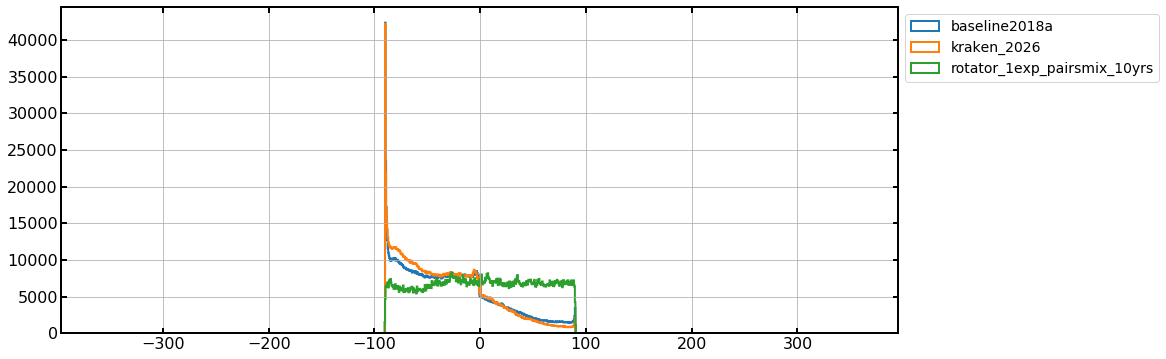

In [6]:
bins = np.arange(-360, 360, 0.5)
for db in simdatas:
    plt.hist(simdatas[db]['rotTelPos'], bins=bins, label=db, histtype='step', lw=2)
plt.legend(bbox_to_anchor=(1,1))

**Set up to plot things**

In [7]:
# want specific ordering of the dbs so write them out
dbs = ['baseline2018a', 'kraken_2026', 'rotator_1exp_pairsmix_10yrs']

In [8]:
ndbs = len(dbs)

from matplotlib import cm
colors = [cm.viridis(i) for i in np.arange(0, 255, int(255/ndbs))]

if len(colors)<ndbs: raise ValueError('Not enough colors.')

**Figure out the min, maxs on the arrays**

In [9]:
dbs = ['baseline2018a', 'kraken_2026'] #, 'rotator_1exp_pairsmix_10yrs']

mins = {'tel': 100, 'dithtel': 100, 'sky': 100, 'dithsky': 10}
maxs = {'tel': -100, 'dithtel': -100, 'sky': -100, 'dithsky': -100}
for db in dbs:
    # add dithered rotSkyPos to the dictionary
    simdatas[db]['randomDitherPerFilterChangeRotSkyPos'] = simdatas[db]['randomDitherPerFilterChangeRotTelPos']-simdatas[db]['PA']
    # look at the min, max
    mins['tel'] = min(mins['tel'], min(simdatas[db]['rotTelPos']))
    mins['dithtel'] = min(mins['dithtel'], min(simdatas[db]['randomDitherPerFilterChangeRotTelPos']))
    mins['sky'] = min(mins['sky'], min(simdatas[db]['rotSkyPos']))
    mins['dithsky'] = min(mins['dithsky'], min(simdatas[db]['randomDitherPerFilterChangeRotSkyPos']))
    
    maxs['tel'] = max(maxs['tel'], max(simdatas[db]['rotTelPos']))
    maxs['dithtel'] = max(maxs['dithtel'], max(simdatas[db]['randomDitherPerFilterChangeRotTelPos']))
    maxs['sky'] = max(maxs['sky'], max(simdatas[db]['rotSkyPos']))
    maxs['dithsky'] = max(maxs['dithsky'], max(simdatas[db]['randomDitherPerFilterChangeRotSkyPos']))
    
print('mins: %s\nmaxs: %s'%(mins, maxs))

mins: {'tel': -90.0, 'dithtel': -90.0, 'sky': 0.00016828919191168483, 'dithsky': -269.61418358212256}
maxs: {'tel': 90.0, 'dithtel': 90.0, 'sky': 359.99989303023597, 'dithsky': 269.7925116289927}


Okay dithered rotSkyPos range is not the same as undithered one. Wrap the dithered values.

In [10]:
mins = {'tel': 100, 'dithtel': 100, 'sky': 100, 'dithsky': 10}
maxs = {'tel': -100, 'dithtel': -100, 'sky': -100, 'dithsky': -100}
for db in dbs:
    # wrap the dithered rotSkyPos
    ind = simdatas[db]['randomDitherPerFilterChangeRotSkyPos'] < 0
    simdatas[db]['randomDitherPerFilterChangeRotSkyPos'][ind] += 360
    
    # look at the min, max
    mins['tel'] = min(mins['tel'], min(simdatas[db]['rotTelPos']))
    mins['dithtel'] = min(mins['dithtel'], min(simdatas[db]['randomDitherPerFilterChangeRotTelPos']))
    mins['sky'] = min(mins['sky'], min(simdatas[db]['rotSkyPos']))
    mins['dithsky'] = min(mins['dithsky'], min(simdatas[db]['randomDitherPerFilterChangeRotSkyPos']))
    
    maxs['tel'] = max(maxs['tel'], max(simdatas[db]['rotTelPos']))
    maxs['dithtel'] = max(maxs['dithtel'], max(simdatas[db]['randomDitherPerFilterChangeRotTelPos']))
    maxs['sky'] = max(maxs['sky'], max(simdatas[db]['rotSkyPos']))
    maxs['dithsky'] = max(maxs['dithsky'], max(simdatas[db]['randomDitherPerFilterChangeRotSkyPos']))

print('mins: %s\nmaxs: %s'%(mins, maxs))

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2019_15/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mins: {'tel': -90.0, 'dithtel': -90.0, 'sky': 0.00016828919191168483, 'dithsky': 6.505275980117631e-06}
maxs: {'tel': 90.0, 'dithtel': 90.0, 'sky': 359.99989303023597, 'dithsky': 359.9998235196824}


The ranges are now similar for dithered and undithered cases.

**Plot distributions**

In [11]:
bins_telpos = np.arange(-92, 92, 0.5)
bins_skypos = np.arange(-2, 362, 0.5)
bins_pa = np.arange(-182, 182, 0.5)

Saved compare_rot_angles_nodith_wdith_3dbs_restrictedylims.png


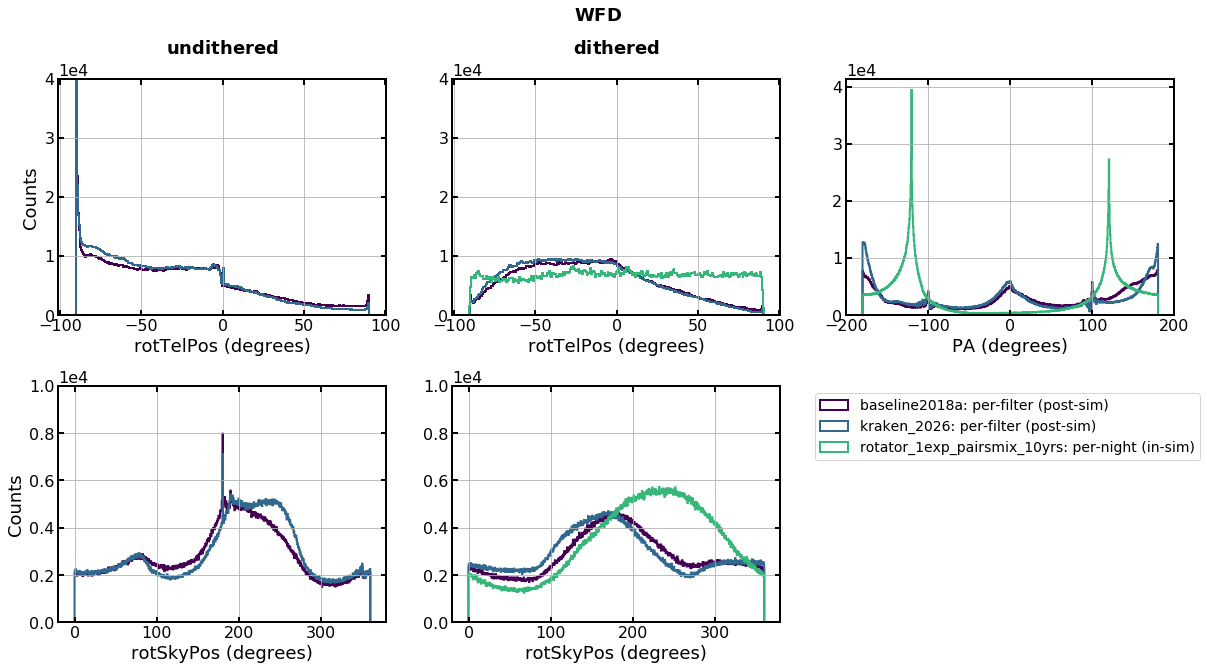

In [12]:
# histograms of the angles
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for i, db in enumerate(dbs):
    if db in simdatas:
        # undithered rotTelPos
        axes[0, 0].hist(simdatas[db]['rotTelPos'], bins=bins_telpos,
                        color=colors[i], histtype='step', lw=2)
        # dithered rotTelPos
        axes[0, 1].hist(simdatas[db]['randomDitherPerFilterChangeRotTelPos'],
                       bins=bins_telpos, color=colors[i], histtype='step', lw=2)
        # undithered rotSkyPos
        axes[1, 0].hist(simdatas[db]['rotSkyPos'],
                        bins=bins_skypos, color=colors[i], histtype='step', lw=2)
        # dithered rotSkyPos
        axes[1, 1].hist(simdatas[db]['randomDitherPerFilterChangeRotSkyPos'],
                         label='%s: per-filter (post-sim)'%db, 
                        bins=bins_skypos, color=colors[i], histtype='step', lw=2)
        # parallactic angle
        axes[0, 2].hist(simdatas[db]['PA'],
                        bins=bins_pa, color=colors[i], histtype='step', lw=2)
# now plot things for the new db
db = 'rotator_1exp_pairsmix_10yrs'
i += 1
# rotTelPos
axes[0, 1].hist(simdatas[db]['rotTelPos'], bins=bins_telpos,
                color=colors[i], histtype='step', lw=2)
# rotSkyPos
axes[1, 1].hist(simdatas[db]['rotSkyPos'],
                label='%s: per-night (in-sim)'%db,
                bins=bins_skypos, color=colors[i], histtype='step', lw=2)
# parallactic angle
axes[0, 2].hist(simdatas[db]['PA'],
                bins=bins_pa, color=colors[i], histtype='step', lw=2)
# set some details
ymax_tel, ymax_sky = 4*10**4, 1*10**4
for row in range(nrows):
    for col in range(ncols):
        axes[row, col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    for col in [0, 1]:
        axes[0, col].set_ylim(0, ymax_tel)
        axes[1, col].set_ylim(0, ymax_sky)
        axes[row, 0].set_ylabel('Counts')
        axes[0, col].set_xlabel('rotTelPos (degrees)')
        axes[1, col].set_xlabel('rotSkyPos (degrees)')
axes[0, 2].set_xlabel('PA (degrees)')
axes[1, 1].legend(bbox_to_anchor=(2.3,1))
axes[1, 2].axis('off')
axes[0, 0].set_title(r'$\bf{undithered}$', fontsize=fontsize, y=1.08)
axes[0, 1].set_title(r'$\bf{dithered}$', fontsize=fontsize, y=1.08)

plt.suptitle(r'$\bf{WFD}$', fontsize=fontsize )
fig.set_size_inches(20,10)
filename = 'compare_rot_angles_nodith_wdith_%sdbs_restrictedylims.png'%(i+1)
plt.savefig('%s/%s'%(outdir, filename), format= 'png', bbox_inches='tight')
print('Saved %s'%filename)

plt.show()